## Capstone Model Building

This is our inital passes at a few machine learning models designed to predict NHL player performance in an ESPN fantasy league. 

In [2]:
## set up packages and import saved flat file
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sb
import researchpy as rp
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, GridSearchCV, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
## import our now cleaned flat file, remind ourselves what it looks like

model_data = pd.read_csv('model_ready_data.csv')
model_data.head()

,Player,Team,Year,Position,Fantasy Points,GP,TOI,IPP,SHPer,iCF,...,Weight_(lbs),Draft_Round,Round_Pick,Overall_Draft_Position,drafted,Total Minutes Played,C,D,L,R
0,Aaron Ness,NYI,2014,D,25.80,20,275.25,100.0,4.35,48,...,184,2.0,10.0,40.0,1,295.88,0,1,0,0
1,Aaron Palushaj,CAR,2014,R,0.95,2,17.52,0.0,0.00,4,...,187,2.0,14.0,44.0,1,18.65,0,0,0,1
2,Aaron Rome,DAL,2014,D,27.50,25,301.20,10.0,0.00,36,...,220,4.0,8.0,104.0,1,327.20,0,1,0,0
3,Aaron Volpatti,WSH,2014,L,32.25,41,300.18,50.0,11.11,39,...,215,100.0,100.0,1000.0,0,301.87,0,0,1,0
4,Adam Almquist,DET,2014,D,3.45,2,31.52,50.0,50.00,3,...,174,7.0,29.0,210.0,1,34.43,0,1,0,0


In [4]:
# we need to reset the index and split into target and features 
model_data.set_index(keys=['Player','Team','Year','Position'],inplace=True)
Target = model_data.iloc[:,0].values  
features = model_data.iloc[:, 1:].values 
X_train, X_test, y_train, y_test = train_test_split(features, Target, test_size=0.2, random_state=0)  

Initially we'll start with a random forest regressor

In [4]:
## fitting without parameter tuning
regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Making intial predictions and charting performance

In [5]:
y_pred = regressor.predict(X_test)  
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regreessor Score:',RandomForestRegressor.score(regressor,X_test,  y_test))

Mean Absolute Error: 11.753717660292464
Mean Squared Error: 295.7487059898763
Root Mean Squared Error: 17.19734589958219
Regreessor Score: 0.9514555313337327


Examining the features

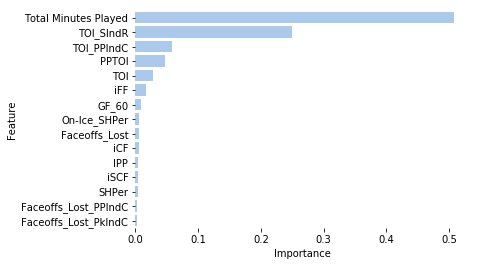

In [6]:
feature_import= list(zip(regressor.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)

Looking at features scores it's interesting that time again holds a lot of import. What I dislike here is that's not really something that we can then use as predictive value since that's a coaching decision, not a player skill.

Let's try some grid searching to see where we can find some improvements.

In [ ]:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


param_grid = {"max_depth": [10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[20,50,100],
              "bootstrap": [True, False]}

# run grid search
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
start = time.gmtime()
grid_search.fit(X_train,  y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test) 

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regressor Score:',RandomForestRegressor.score(best_grid,X_test,  y_test))

The grid search did improve some but not a ton across the board, other than in MSE, which makes sense as that's the metric it's scoring on.

| Metric      | Original          | Grid Search  | 
| ------------- |:-------------:| -----:| 
| Mean Absolute Error:    |  11.75 | **11.2** | 
| Mean Squared Error:    |  295.75 | **264.45** | 
| Root Mean Squared Error:     |  17.2 | **16.26** | 
| Regressor Score:    |  0.95 | **0.96** | 
    


In [ ]:
## checking how feature importance has changed
feature_import= list(zip(best_grid.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features_grid = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)

In [ ]:
## for fun I decided to re run the above using just the top 15 features, to see if triming 
## the options would reduce noise even further
feature_list = top_features_grid.Feature.unique()
trimmed_features = model_data.loc[:,feature_list].values 
trimmed_X_train, trimmed_X_test, trimmed_y_train, trimmed_y_test = train_test_split(trimmed_features, Target, test_size=0.2, random_state=0) 

In [ ]:
trimmed_regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
trimmed_regressor.fit(trimmed_X_train, trimmed_y_train)
# run grid search
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5)
start = time.gmtime()
grid_search.fit(trimmed_X_train,  trimmed_y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
trimmed_y_pred = best_grid.predict(trimmed_X_test) 

print('Mean Absolute Error:', metrics.mean_absolute_error(trimmed_y_test, trimmed_y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(trimmed_y_test, trimmed_y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trimmed_y_test, trimmed_y_pred))) 
print('Regressor Score:',RandomForestRegressor.score(best_grid,trimmed_X_test,  trimmed_y_test))

So that backfired in that it significantly increased the errors, especially on MSE, which is pretty significant.

Let's move on and try some more classic models

In [72]:
## linear regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) 
print(lin_reg.intercept_)

87.15018870475052


In [73]:
y_pred = lin_reg.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df[1:20]

,Actual,Predicted
1,14.35,16.345904
2,233.65,199.122168
3,141.50,153.884523
4,185.85,200.685100
5,150.95,164.722377
6,135.25,130.762171
7,75.00,91.965385
8,158.80,176.621316
9,108.85,109.707626
10,120.45,144.194733


This is sort of goofy in that there are negative values, which I'm sure there should be some way to prevent in the code. From a glance they're low value players anyway, but it's still seems less than ideal. 

In [74]:
## looking at metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 
print('Regressor Score:',LinearRegression.score(lin_reg,X_test,  y_test))

Mean Absolute Error: 12.528944160797773
Mean Squared Error: 280.0456966076711
Root Mean Squared Error: 16.734565922296017
Regressor Score: 0.9540330379516203


Well this is a close but no cigar type item. The RMSE was about the same, but in every other area 

| Metric      | Linear Regression         | Grid Search  | 
| ------------- |:-------------:| -----:| 
| Mean Absolute Error:    |  12.53 | **11.2** | 
| Mean Squared Error:    |  280.05 | **264.45** | 
| Root Mean Squared Error:     |  16.73 | **16.26** | 
| Regressor Score:    |  0.95 | **0.96** | 

In [75]:
## let's try some gradient decent

from sklearn.linear_model import SGDRegressor

stgd = SGDRegressor()
stgd.fit(X_train, y_train)
sty_pred = stgd.predict(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, sty_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, sty_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, sty_pred))) 
print('Regressor Score:',LinearRegression.score(stgd,X_test,  y_test))

In [ ]:
sty_pred

In [ ]:
from sklearn.svm import SVR
svr_lin = SVR(kernel='linear')

y_lin = svr_lin.fit(X_train, y_train).predict(X_test)

In [ ]:
y_lin



In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_lin))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_lin))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_lin))) 
print('Regressor Score:',LinearRegression.score(svr_lin,X_test,  y_test))

In [6]:
from sklearn import ensemble
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf_pred = clf.fit(X_train, y_train).predict(X_test)



In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, clf_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, clf_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred))) 
print('Regressor Score:',LinearRegression.score(clf,X_test,  clf_pred))

In [ ]:
feature_import= list(zip(clf.feature_importances_, model_data.columns[1:]))
feature_import = pd.DataFrame(feature_import, columns = ['Importance', 'Feature'])
top_features = feature_import.sort_values(by='Importance', ascending=False)[0:15]
# quick plot of values
sb.set_color_codes("pastel")
sb.barplot(x='Importance', y="Feature", data=top_features, color="b")
sb.despine(left=True, bottom=True)

This is the first model to outperform the cross-validated Random Forest Regressor, and perhaps as interesting the first to move to Fenwick up to the top three. Time factors sill dominate but not as much.  Also perhaps to have significant improvements across the board as far as errors.

| Metric      | Linear Regression         | Grid Search  | Gradient Boost  |
| ------------- |:-------------:| -----:| -----:| 
| Mean Absolute Error:    |  12.53 | 11.2 | **10.13** |
| Mean Squared Error:    |  280.05 | 264.45 | **209.94** |  
| Root Mean Squared Error:     |  16.73 | 16.26 |  **14.49** | 
| Regressor Score:    |  0.95 | 0.96 |  **1** | 

In [ ]:


clfparam_grid = {"max_depth": [4, 10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[500,600,700]}

# run grid search
clfgrid_search = GridSearchCV(clf, param_grid=clfparam_grid, cv=5)
start = time.gmtime()
clf_grid = clfgrid_search.fit(X_train,  y_train).predict(X_test)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(clfgrid_search.cv_results_['params'])))
clfgrid_search.best_params_

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, clf_grid))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, clf_grid))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, clf_grid))) 
print('Regressor Score:',LinearRegression.score(clf,X_test,  clf_grid))

This actually performs worse than the first options. I'm thinking it's becuase I eliminated the 'none' options so I'm rerunning with that added back in. Score comparisions:

| Metric      | Linear Regression         | Grid Search  | Gradient Boost  | Grid and Gradient  |
| ------------- |-------------:| -----:| -----:| -----:| 
| Mean Absolute Error:    |  12.53 | 11.2 | **10.13** | 10.26 |
| Mean Squared Error:    |  280.05 | 264.45 | **209.94** |  220.11 |
| Root Mean Squared Error:     |  16.73 | 16.26 |  **14.49** | 14.84 |
| Regressor Score:    |  0.95 | 0.96 |  **1** | .99 |


In [ ]:

clfparam_grid2 = {"max_depth": [ None,  10],
              "max_features": [None, 10],
              "min_samples_split": [2, 3, 10],
              'n_estimators':[700,800],
                 
                }

# run grid search
clfgrid_search2 = GridSearchCV(clf, param_grid=clfparam_grid2, cv=5)
start = time.gmtime()
clf_grid2 = clfgrid_search2.fit(X_train,  y_train).predict(X_test)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.mktime(time.gmtime()) - time.mktime(start), len(grid_search.cv_results_['params'])))
clfgrid_search.best_params_

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, clf_grid2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, clf_grid2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, clf_grid2))) 
print('Regressor Score:',LinearRegression.score(clf,X_test,  clf_grid2))

In [ ]:
clfgrid_search.

In [ ]:
clfgrid_search.best_params_

In [ ]:
clfgrid_search